In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import random
from tqdm import tqdm


Make a rendering function and test it with just random wandering strategy

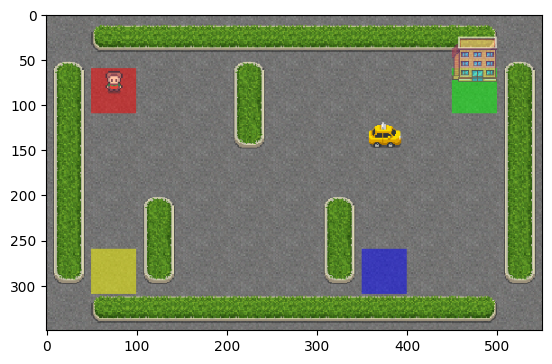

In [2]:
def visualize(action_strategy, max_steps = 100):
    env = gym.make("Taxi-v3", render_mode="rgb_array")

    state, _ = env.reset()
    img = plt.imshow(env.render())

    done = False
    terminated = False
    steps = 0

    while not done and not terminated and steps < max_steps:
        steps += 1
        action = action_strategy(env, state)
        state, _, done, terminated, _ = env.step(action)
        
        frame = env.render()
        img.set_data(frame)

        display.display(plt.gcf())
        display.clear_output(wait=True)

    env.close()

visualize(lambda env, state: env.action_space.sample(), 10)


Create environment and peek at it

In [3]:
env = gym.make("Taxi-v3", render_mode="ansi")
print(env.observation_space)
print(env.action_space)
state, _ = env.reset()
print(state)
print(env.render())


Discrete(500)
Discrete(6)
401
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Parameters for our solution

In [4]:
#parameters
alpha = 0.4  # learning rate
gamma = 0.9  # discount coeff
epsilon = 0.1  # exploration vs exploit
episodes_count = 1000

# initializing q-table with zeros
Q = np.zeros((env.observation_space.n, env.action_space.n))

Train loop: select action (based on Q table) -> update environment state -> update Q table towards optimization

Here's the formula for Q function update (alpha is learning rate) - Bellman equation


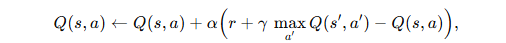

In [5]:
history = []
terminated_count = 0;
done_count = 0;

for episode in tqdm(range(episodes_count)):
    state, _ = env.reset()
    done = False
    terminated = False
    total_reward = 0
    while not done and not terminated:
        #choose an action, optimal from Q table, but with epsilon probability use a random one (for exploration)
        action = np.argmax(Q[state]) if (random.uniform(0, 1) > epsilon) else env.action_space.sample()
        #make a step based on selected action
        new_state, reward, done, terminated, _ = env.step(action)

        #let's track outcomes and see if episodes are getting complete succesfully or terminated
        if terminated: terminated_count += 1
        if done: done_count += 1

        #updating Q table
        #the idea is that the change is proportional to reward plus difference between 
        # usefulness of the current state+action vs potential usefullness of the new state (for the best possible action, hence max)
        Q[state, action] = Q[state, action] + alpha * (
            reward + gamma * np.max(Q[new_state]) - Q[state, action])
        
        state = new_state
        total_reward += reward
    
    history.append((total_reward, done_count, terminated_count))

env.close()

100%|██████████| 1000/1000 [00:02<00:00, 400.54it/s] 


In [6]:
print(f"terminated: {terminated_count} times")
print(f"done: {done_count} times")

terminated: 58 times
done: 942 times


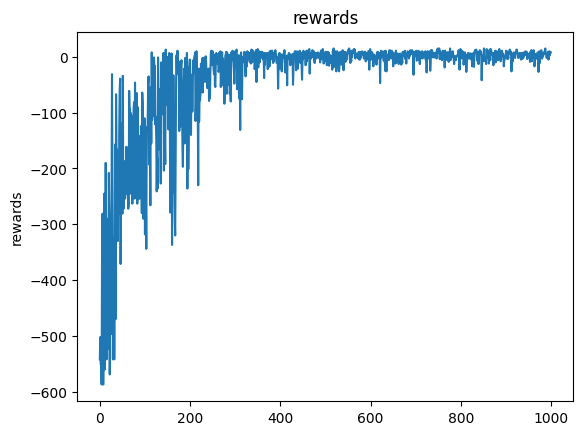

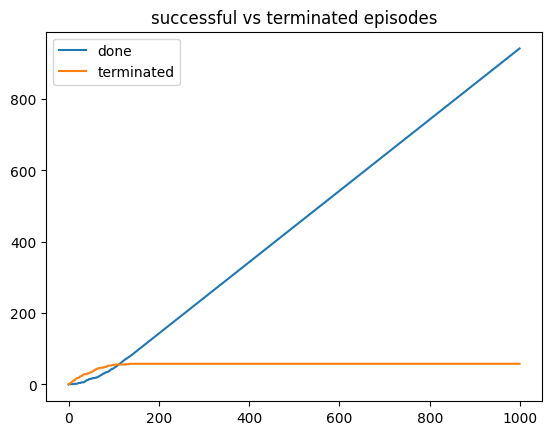

In [ ]:
plt.plot([r[0] for r in history])
plt.ylabel("rewards")
plt.title("rewards")
plt.show()
plt.plot([r[1] for r in history], label="done")
plt.plot([r[2] for r in history], label="terminated")
plt.legend()
plt.title("successful vs terminated episodes")
plt.show()



Let's draw average reward for last 100 episodes (as per original task)

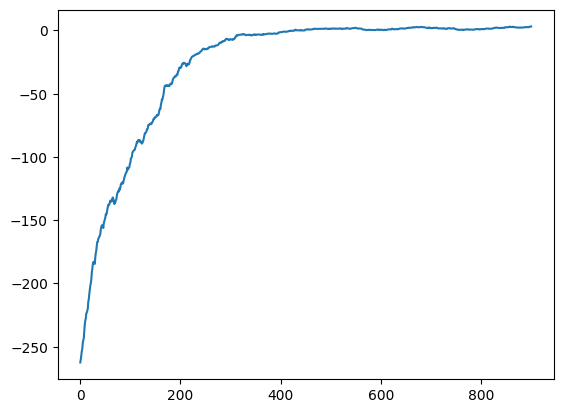

In [23]:
#the idea here is thataverage of 100 last values 
# is effectively convolution with a kernel of 100 ones

kernel = np.ones(100)
rolling_sums = np.convolve([r[0] for r in history], kernel, mode='valid')
rolling_means = rolling_sums / 100
plt.plot(rolling_means)
plt.show()

Normally we should validate our model here but from success/terminated plot it's clear our last few hundered of iterations were fine: 

successful 'done' conter grows linearly while 'terminated' counter stays flat

Let's visualize a run of our model

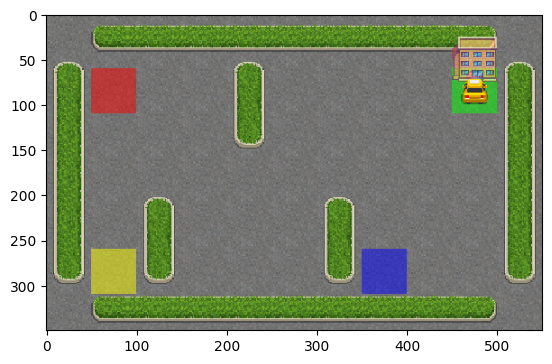

In [24]:
visualize(lambda env, state : np.argmax(Q[state]))